In [61]:
%reset -f

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from scipy.stats import linregress

In [63]:
df_r = pd.read_excel('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/Dataset_EUA_24_Daily_Returns.xlsx')
df_r = df_r.drop(columns=['Date'])

In [64]:
scaler = StandardScaler()
data_r_s = scaler.fit_transform(df_r.iloc[:,:])
df_r_s = pd.DataFrame(data_r_s, columns=df_r.columns[:])

In [65]:
labels = [
    'EUA', 'GPR', 'VSTOXX', 'UncEURUSD', 'UncEURJPY', 'UncEURGBP', 'UncEURCHF',
    'NatGas', 'ElecES', 'ElecDE', 'ElecFR', 'CoalFut', 'CuFut', 'Brent',
    'AgFut', 'Gold', 'EURUSD', 'EURJPY', 'EURGBP', 'EURCHF', 'WHNewEnergy',
    'BbgEnergy', 'SolCEA', 'ESTXElect', 'SEF EU50', 'LC100EU', 'MSCIEnrg',
    'ERIX', 'Euronext100', 'IBEX35', 'DAX', 'CAC', 'FTSEmib', 'Bund10y', 'Bond3m'
]

In [66]:
df_r_s.columns = labels
df_r.columns = labels

In [67]:
model = VAR(df_r_s)
var_model = model.fit(1, trend='n', verbose=True)  # 1 lag


In [68]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 29, Dec, 2024
Time:                     17:24:15
--------------------------------------------------------------------
No. of Equations:         35.0000    BIC:                   -27.6283
Nobs:                     2901.00    HQIC:                  -29.2417
Log likelihood:          -99113.7    FPE:                8.05066e-14
AIC:                     -30.1505    Det(Omega_mle):     5.29103e-14
--------------------------------------------------------------------
Results for equation EUA
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
L1.EUA                 0.069930         0.145124            0.482           0.630
L1.GPR                 0.001734         0.018607            0.093           0.926
L1.VSTOXX             -0.024736         0.028986          

In [69]:
causality_results = []

for var in df_r_s.columns:
    causality = var_model.test_causality('EUA', var, kind='f')
    
    causality_results.append({
        'Excluded Variable': var,
        'F-Statistic': causality.test_statistic,
        'p-value': causality.pvalue
    })

causality_results_df = pd.DataFrame(causality_results)

print(causality_results_df)

   Excluded Variable  F-Statistic   p-value
0                EUA     0.232196  0.629902
1                GPR     0.008686  0.925747
2             VSTOXX     0.728266  0.393448
3          UncEURUSD     0.111630  0.738297
4          UncEURJPY     1.025128  0.311308
5          UncEURGBP     2.967336  0.084965
6          UncEURCHF     0.043805  0.834218
7             NatGas     0.274736  0.600173
8             ElecES     0.070379  0.790786
9             ElecDE     0.558294  0.454950
10            ElecFR     3.349793  0.067216
11           CoalFut     4.618590  0.031630
12             CuFut     2.364431  0.124132
13             Brent     3.442855  0.063529
14             AgFut     0.076970  0.781448
15              Gold     2.928786  0.087016
16            EURUSD     0.043134  0.835473
17            EURJPY     0.000475  0.982607
18            EURGBP     1.328857  0.249011
19            EURCHF     0.918890  0.337769
20       WHNewEnergy     0.167131  0.682675
21         BbgEnergy     1.00802

In [70]:
causality_results_df = causality_results_df.sort_values(by='F-Statistic', ascending=False)
print(causality_results_df)

   Excluded Variable  F-Statistic   p-value
29            IBEX35     6.730715  0.009478
11           CoalFut     4.618590  0.031630
31               CAC     3.624748  0.056929
13             Brent     3.442855  0.063529
10            ElecFR     3.349793  0.067216
5          UncEURGBP     2.967336  0.084965
15              Gold     2.928786  0.087016
33           Bund10y     2.797166  0.094434
12             CuFut     2.364431  0.124132
24          SEF EU50     2.360204  0.124469
18            EURGBP     1.328857  0.249011
32           FTSEmib     1.147268  0.284124
4          UncEURJPY     1.025128  0.311308
21         BbgEnergy     1.008026  0.315379
19            EURCHF     0.918890  0.337769
27              ERIX     0.864646  0.352444
34            Bond3m     0.828644  0.362667
2             VSTOXX     0.728266  0.393448
9             ElecDE     0.558294  0.454950
22            SolCEA     0.284212  0.593955
7             NatGas     0.274736  0.600173
0                EUA     0.23219

In [71]:
eua_var_coef = abs(var_model.params['EUA'])
eua_var_coef = eua_var_coef.sort_values(ascending=False)
print(eua_var_coef)

L1.CAC            0.215872
L1.SEF EU50       0.164051
L1.IBEX35         0.144009
L1.Brent          0.133369
L1.ElecFR         0.130926
L1.SolCEA         0.077392
L1.EUA            0.069930
L1.Euronext100    0.054364
L1.FTSEmib        0.053869
L1.CoalFut        0.047420
L1.Gold           0.044886
L1.UncEURGBP      0.033962
L1.CuFut          0.032765
L1.Bund10y        0.031167
L1.DAX            0.028737
L1.ERIX           0.026315
L1.VSTOXX         0.024736
L1.EURGBP         0.022890
L1.BbgEnergy      0.022131
L1.UncEURJPY      0.020441
L1.EURCHF         0.018625
L1.LC100EU        0.017553
L1.Bond3m         0.016882
L1.ElecDE         0.014300
L1.NatGas         0.011563
L1.WHNewEnergy    0.011190
L1.ESTXElect      0.008815
L1.AgFut          0.007493
L1.MSCIEnrg       0.006825
L1.UncEURUSD      0.006507
L1.ElecES         0.005579
L1.EURUSD         0.004372
L1.UncEURCHF      0.003984
L1.GPR            0.001734
L1.EURJPY         0.000457
Name: EUA, dtype: float64


In [72]:
eua_var_coef.index = eua_var_coef.index.str.replace('L1.', '')
print(eua_var_coef)

CAC            0.215872
SEF EU50       0.164051
IBEX35         0.144009
Brent          0.133369
ElecFR         0.130926
SolCEA         0.077392
EUA            0.069930
Euronext100    0.054364
FTSEmib        0.053869
CoalFut        0.047420
Gold           0.044886
UncEURGBP      0.033962
CuFut          0.032765
Bund10y        0.031167
DAX            0.028737
ERIX           0.026315
VSTOXX         0.024736
EURGBP         0.022890
BbgEnergy      0.022131
UncEURJPY      0.020441
EURCHF         0.018625
LC100EU        0.017553
Bond3m         0.016882
ElecDE         0.014300
NatGas         0.011563
WHNewEnergy    0.011190
ESTXElect      0.008815
AgFut          0.007493
MSCIEnrg       0.006825
UncEURUSD      0.006507
ElecES         0.005579
EURUSD         0.004372
UncEURCHF      0.003984
GPR            0.001734
EURJPY         0.000457
Name: EUA, dtype: float64


In [73]:
eua_var_coef = eua_var_coef.reset_index()
eua_var_coef.columns = ['Variable', 'VAR Coeff.']
print(eua_var_coef)

       Variable  VAR Coeff.
0           CAC    0.215872
1      SEF EU50    0.164051
2        IBEX35    0.144009
3         Brent    0.133369
4        ElecFR    0.130926
5        SolCEA    0.077392
6           EUA    0.069930
7   Euronext100    0.054364
8       FTSEmib    0.053869
9       CoalFut    0.047420
10         Gold    0.044886
11    UncEURGBP    0.033962
12        CuFut    0.032765
13      Bund10y    0.031167
14          DAX    0.028737
15         ERIX    0.026315
16       VSTOXX    0.024736
17       EURGBP    0.022890
18    BbgEnergy    0.022131
19    UncEURJPY    0.020441
20       EURCHF    0.018625
21      LC100EU    0.017553
22       Bond3m    0.016882
23       ElecDE    0.014300
24       NatGas    0.011563
25  WHNewEnergy    0.011190
26    ESTXElect    0.008815
27        AgFut    0.007493
28     MSCIEnrg    0.006825
29    UncEURUSD    0.006507
30       ElecES    0.005579
31       EURUSD    0.004372
32    UncEURCHF    0.003984
33          GPR    0.001734
34       EURJPY    0

In [74]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/weights_DII_E1_returns.p', 'rb') as file:
    DII_Rets_1 = pickle.load(file)

In [75]:
df_DII_Rets_1 = pd.DataFrame(DII_Rets_1)
df_DII_Rets_1.columns = ['DII Coeff.']
print(df_DII_Rets_1)

      DII Coeff.
0   5.178249e-02
1   1.505711e-02
2   6.470429e-02
3   0.000000e+00
4   2.802597e-45
5   5.625516e-02
6   5.937924e-02
7   1.401298e-45
8   1.909872e-01
9   1.020297e-01
10  1.353509e-01
11  6.108686e-02
12  2.635746e-02
13  2.639674e-02
14  1.485274e-29
15  3.519808e-02
16  0.000000e+00
17  4.756996e-02
18  5.825070e-02
19  1.401298e-45
20  0.000000e+00
21  4.111340e-02
22  4.302184e-02
23  0.000000e+00
24  0.000000e+00
25  3.488656e-02
26  1.401298e-45
27  9.809089e-45
28  1.782125e-01
29  8.663016e-02
30  7.036368e-40
31  1.352163e-01
32  0.000000e+00
33  1.955268e-01
34  3.980623e-01


In [76]:
df_DII_Rets_1['Variable'] = labels
df_DII_Rets_1 = df_DII_Rets_1[['Variable', 'DII Coeff.']]
print(df_DII_Rets_1)

       Variable    DII Coeff.
0           EUA  5.178249e-02
1           GPR  1.505711e-02
2        VSTOXX  6.470429e-02
3     UncEURUSD  0.000000e+00
4     UncEURJPY  2.802597e-45
5     UncEURGBP  5.625516e-02
6     UncEURCHF  5.937924e-02
7        NatGas  1.401298e-45
8        ElecES  1.909872e-01
9        ElecDE  1.020297e-01
10       ElecFR  1.353509e-01
11      CoalFut  6.108686e-02
12        CuFut  2.635746e-02
13        Brent  2.639674e-02
14        AgFut  1.485274e-29
15         Gold  3.519808e-02
16       EURUSD  0.000000e+00
17       EURJPY  4.756996e-02
18       EURGBP  5.825070e-02
19       EURCHF  1.401298e-45
20  WHNewEnergy  0.000000e+00
21    BbgEnergy  4.111340e-02
22       SolCEA  4.302184e-02
23    ESTXElect  0.000000e+00
24     SEF EU50  0.000000e+00
25      LC100EU  3.488656e-02
26     MSCIEnrg  1.401298e-45
27         ERIX  9.809089e-45
28  Euronext100  1.782125e-01
29       IBEX35  8.663016e-02
30          DAX  7.036368e-40
31          CAC  1.352163e-01
32      FT

In [77]:
df_DII_Rets_1 = df_DII_Rets_1.sort_values(by='DII Coeff.', ascending=False)
print(df_DII_Rets_1)

       Variable    DII Coeff.
34       Bond3m  3.980623e-01
33      Bund10y  1.955268e-01
8        ElecES  1.909872e-01
28  Euronext100  1.782125e-01
10       ElecFR  1.353509e-01
31          CAC  1.352163e-01
9        ElecDE  1.020297e-01
29       IBEX35  8.663016e-02
2        VSTOXX  6.470429e-02
11      CoalFut  6.108686e-02
6     UncEURCHF  5.937924e-02
18       EURGBP  5.825070e-02
5     UncEURGBP  5.625516e-02
0           EUA  5.178249e-02
17       EURJPY  4.756996e-02
22       SolCEA  4.302184e-02
21    BbgEnergy  4.111340e-02
15         Gold  3.519808e-02
25      LC100EU  3.488656e-02
13        Brent  2.639674e-02
12        CuFut  2.635746e-02
1           GPR  1.505711e-02
14        AgFut  1.485274e-29
30          DAX  7.036368e-40
27         ERIX  9.809089e-45
4     UncEURJPY  2.802597e-45
19       EURCHF  1.401298e-45
26     MSCIEnrg  1.401298e-45
7        NatGas  1.401298e-45
23    ESTXElect  0.000000e+00
20  WHNewEnergy  0.000000e+00
16       EURUSD  0.000000e+00
32      FT

In [78]:
merged_df = pd.merge(eua_var_coef, df_DII_Rets_1, on='Variable', how='inner')
print(merged_df)

       Variable  VAR Coeff.    DII Coeff.
0           CAC    0.215872  1.352163e-01
1      SEF EU50    0.164051  0.000000e+00
2        IBEX35    0.144009  8.663016e-02
3         Brent    0.133369  2.639674e-02
4        ElecFR    0.130926  1.353509e-01
5        SolCEA    0.077392  4.302184e-02
6           EUA    0.069930  5.178249e-02
7   Euronext100    0.054364  1.782125e-01
8       FTSEmib    0.053869  0.000000e+00
9       CoalFut    0.047420  6.108686e-02
10         Gold    0.044886  3.519808e-02
11    UncEURGBP    0.033962  5.625516e-02
12        CuFut    0.032765  2.635746e-02
13      Bund10y    0.031167  1.955268e-01
14          DAX    0.028737  7.036368e-40
15         ERIX    0.026315  9.809089e-45
16       VSTOXX    0.024736  6.470429e-02
17       EURGBP    0.022890  5.825070e-02
18    BbgEnergy    0.022131  4.111340e-02
19    UncEURJPY    0.020441  2.802597e-45
20       EURCHF    0.018625  1.401298e-45
21      LC100EU    0.017553  3.488656e-02
22       Bond3m    0.016882  3.980

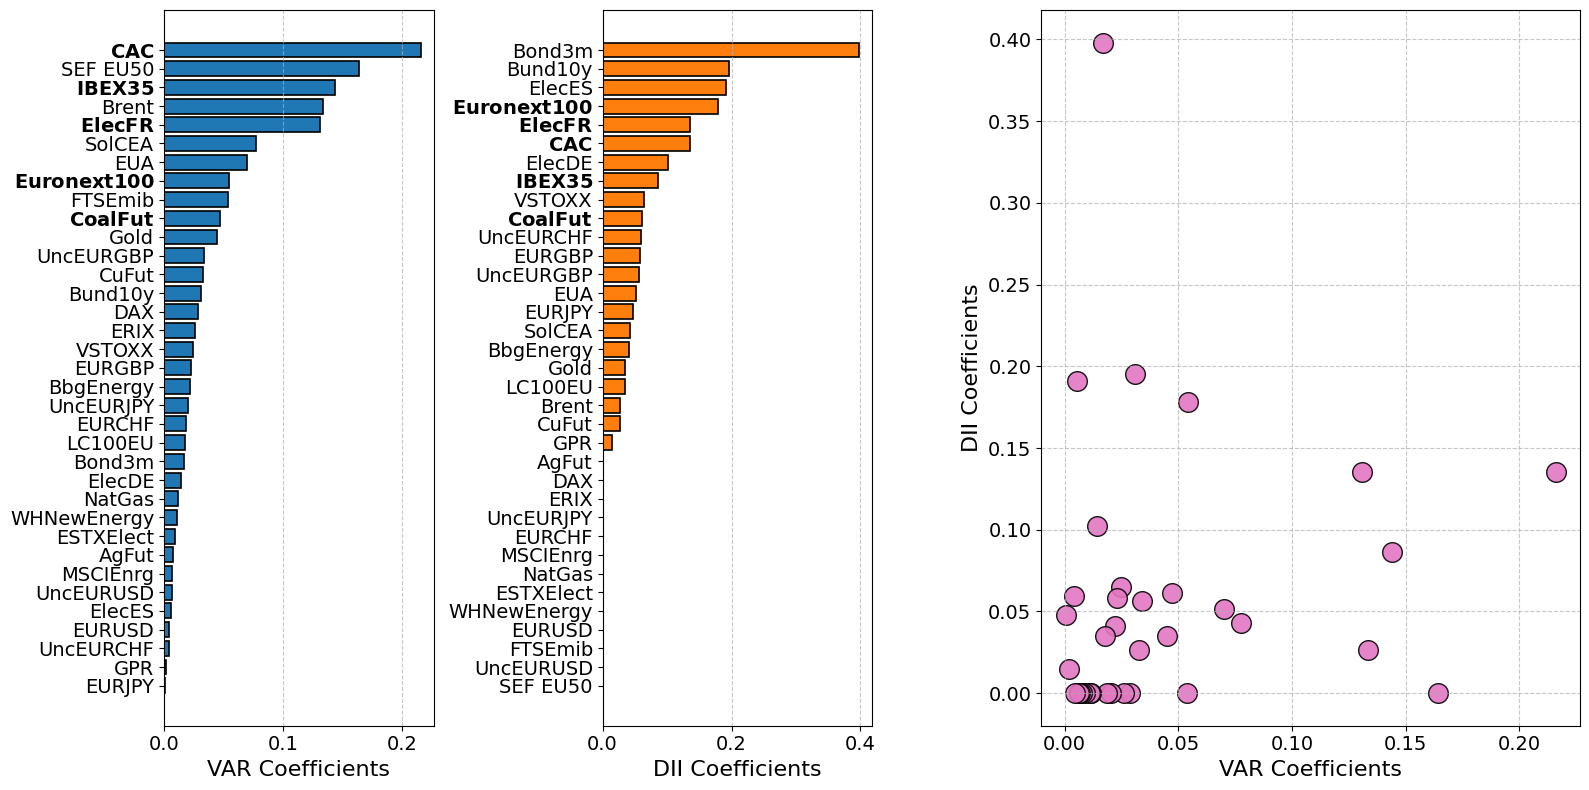

In [79]:
bold_vars = ["CoalFut", "CAC", "IBEX35", "ElecFR", "Euronext100"]

eua_var_coef["Variable"] = eua_var_coef["Variable"].apply(
    lambda x: f"$\\bf{{{x}}}$" if x in bold_vars else x
)

df_DII_Rets_1["Variable"] = df_DII_Rets_1["Variable"].apply(
    lambda x: f"$\\bf{{{x}}}$" if x in bold_vars else x
)

fig, axes = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1, 2]})

bar_kwargs = {"edgecolor": "black", "linewidth": 1.2}

axes[0].barh(
    eua_var_coef["Variable"], 
    eua_var_coef["VAR Coeff."], 
    color='tab:blue', 
    **bar_kwargs
)
axes[0].set_xlabel("VAR Coefficients", fontsize=16)
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

axes[1].barh(
    df_DII_Rets_1["Variable"], 
    df_DII_Rets_1["DII Coeff."], 
    color='tab:orange', 
    **bar_kwargs
)
axes[1].set_xlabel("DII Coefficients", fontsize=16)
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

axes[2].scatter(
    merged_df["VAR Coeff."], 
    merged_df["DII Coeff."], 
    color='tab:pink', 
    alpha=0.9, s=200, edgecolor='black'
)
axes[2].set_xlabel("VAR Coefficients", fontsize=16)
axes[2].set_ylabel("DII Coefficients", fontsize=16)
axes[2].grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


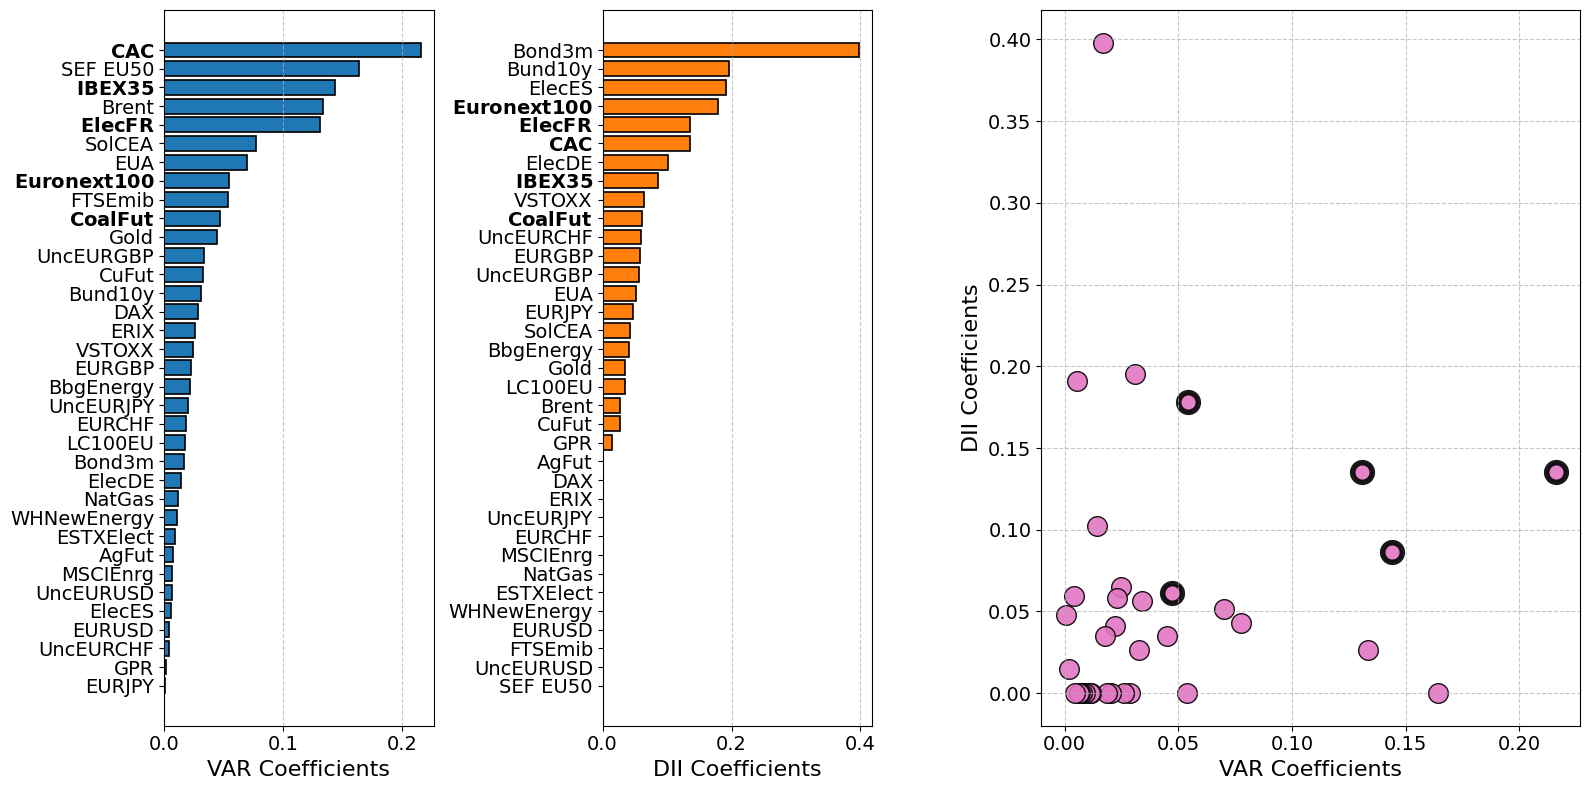

In [80]:
bold_vars = ["CoalFut", "CAC", "IBEX35", "ElecFR", "Euronext100"]

eua_var_coef["Variable"] = eua_var_coef["Variable"].apply(
    lambda x: f"$\\bf{{{x}}}$" if x in bold_vars else x
)

df_DII_Rets_1["Variable"] = df_DII_Rets_1["Variable"].apply(
    lambda x: f"$\\bf{{{x}}}$" if x in bold_vars else x
)

fig, axes = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1, 2]})

bar_kwargs = {"edgecolor": "black", "linewidth": 1.2}

axes[0].barh(
    eua_var_coef["Variable"], 
    eua_var_coef["VAR Coeff."], 
    color='tab:blue', 
    **bar_kwargs
)
axes[0].set_xlabel("VAR Coefficients", fontsize=16)
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

axes[1].barh(
    df_DII_Rets_1["Variable"], 
    df_DII_Rets_1["DII Coeff."], 
    color='tab:orange', 
    **bar_kwargs
)
axes[1].set_xlabel("DII Coefficients", fontsize=16)
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

scatter_kwargs = {
    "color": 'tab:pink', 
    "alpha": 0.9, 
    "s": 200, 
    "edgecolor": 'black'
}

for var in merged_df["Variable"]:
    if var in bold_vars:
        axes[2].scatter(
            merged_df.loc[merged_df["Variable"] == var, "VAR Coeff."], 
            merged_df.loc[merged_df["Variable"] == var, "DII Coeff."], 
            linewidths=4,
            **scatter_kwargs
        )
    else:
        axes[2].scatter(
            merged_df.loc[merged_df["Variable"] == var, "VAR Coeff."], 
            merged_df.loc[merged_df["Variable"] == var, "DII Coeff."], 
            linewidths=1.0,
            **scatter_kwargs
        )

axes[2].set_xlabel("VAR Coefficients", fontsize=16)
axes[2].set_ylabel("DII Coefficients", fontsize=16)
axes[2].grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

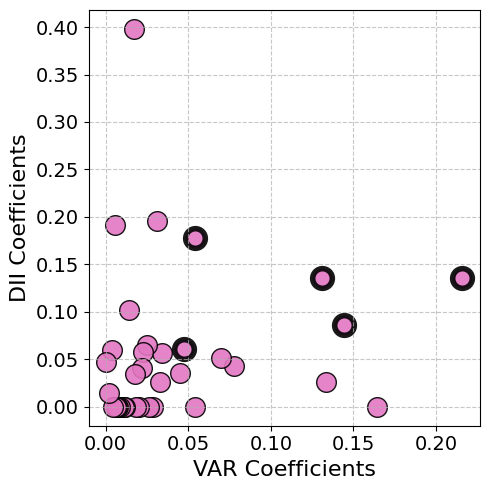

In [81]:
bold_vars = ["CoalFut", "CAC", "IBEX35", "ElecFR", "Euronext100"]

fig, ax = plt.subplots(figsize=(5, 5))

scatter_kwargs = {
    "color": 'tab:pink', 
    "alpha": 0.9, 
    "s": 200, 
    "edgecolor": 'black'
}

for var in merged_df["Variable"]:
    if var in bold_vars:
        ax.scatter(
            merged_df.loc[merged_df["Variable"] == var, "VAR Coeff."], 
            merged_df.loc[merged_df["Variable"] == var, "DII Coeff."], 
            linewidths=4,
            **scatter_kwargs
        )
    else:
        ax.scatter(
            merged_df.loc[merged_df["Variable"] == var, "VAR Coeff."], 
            merged_df.loc[merged_df["Variable"] == var, "DII Coeff."], 
            linewidths=1.0,
            **scatter_kwargs
        )

ax.set_xlabel("VAR Coefficients", fontsize=16)
ax.set_ylabel("DII Coefficients", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

***

In [82]:
causality_results_df = causality_results_df.drop(columns=['p-value'])
causality_results_df.columns = ['Variable', 'F-Statistic']
print(causality_results_df)

       Variable  F-Statistic
29       IBEX35     6.730715
11      CoalFut     4.618590
31          CAC     3.624748
13        Brent     3.442855
10       ElecFR     3.349793
5     UncEURGBP     2.967336
15         Gold     2.928786
33      Bund10y     2.797166
12        CuFut     2.364431
24     SEF EU50     2.360204
18       EURGBP     1.328857
32      FTSEmib     1.147268
4     UncEURJPY     1.025128
21    BbgEnergy     1.008026
19       EURCHF     0.918890
27         ERIX     0.864646
34       Bond3m     0.828644
2        VSTOXX     0.728266
9        ElecDE     0.558294
22       SolCEA     0.284212
7        NatGas     0.274736
0           EUA     0.232196
30          DAX     0.197625
28  Euronext100     0.181797
20  WHNewEnergy     0.167131
3     UncEURUSD     0.111630
14        AgFut     0.076970
8        ElecES     0.070379
23    ESTXElect     0.064005
25      LC100EU     0.052786
26     MSCIEnrg     0.050351
6     UncEURCHF     0.043805
16       EURUSD     0.043134
1           GP

In [83]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/IG_DII_E1_returns.p', 'rb') as file:
    IG_Rets_1 = pickle.load(file)

In [84]:
df_IG_Rets_1 = pd.DataFrame(IG_Rets_1)
df_IG_Rets_1.columns = ['IG Coeff.']
print(df_IG_Rets_1)

    IG Coeff.
0    0.171567
1    0.508545
2    0.380671
3    0.006082
4    0.000000
5    0.000000
6    0.433114
7    0.000000
8    0.608141
9    0.937311
10   0.340444
11   1.796170
12   0.922843
13   0.000000
14   0.002621
15   0.674971
16   0.011690
17   1.090525
18   0.604054
19   0.437728
20   0.000000
21   1.000135
22   0.089482
23   0.819702
24   0.007067
25   0.363217
26   0.000000
27   0.000000
28   0.784301
29   1.425610
30   0.183783
31   0.220709
32   0.000000
33   0.571289
34   1.356129


In [85]:
df_IG_Rets_1['Variable'] = labels
df_IG_Rets_1 = df_IG_Rets_1[['Variable', 'IG Coeff.']]
print(df_IG_Rets_1)

       Variable  IG Coeff.
0           EUA   0.171567
1           GPR   0.508545
2        VSTOXX   0.380671
3     UncEURUSD   0.006082
4     UncEURJPY   0.000000
5     UncEURGBP   0.000000
6     UncEURCHF   0.433114
7        NatGas   0.000000
8        ElecES   0.608141
9        ElecDE   0.937311
10       ElecFR   0.340444
11      CoalFut   1.796170
12        CuFut   0.922843
13        Brent   0.000000
14        AgFut   0.002621
15         Gold   0.674971
16       EURUSD   0.011690
17       EURJPY   1.090525
18       EURGBP   0.604054
19       EURCHF   0.437728
20  WHNewEnergy   0.000000
21    BbgEnergy   1.000135
22       SolCEA   0.089482
23    ESTXElect   0.819702
24     SEF EU50   0.007067
25      LC100EU   0.363217
26     MSCIEnrg   0.000000
27         ERIX   0.000000
28  Euronext100   0.784301
29       IBEX35   1.425610
30          DAX   0.183783
31          CAC   0.220709
32      FTSEmib   0.000000
33      Bund10y   0.571289
34       Bond3m   1.356129


In [86]:
df_IG_Rets_1 = df_IG_Rets_1.sort_values(by='IG Coeff.', ascending=False)
print(df_IG_Rets_1)

       Variable  IG Coeff.
11      CoalFut   1.796170
29       IBEX35   1.425610
34       Bond3m   1.356129
17       EURJPY   1.090525
21    BbgEnergy   1.000135
9        ElecDE   0.937311
12        CuFut   0.922843
23    ESTXElect   0.819702
28  Euronext100   0.784301
15         Gold   0.674971
8        ElecES   0.608141
18       EURGBP   0.604054
33      Bund10y   0.571289
1           GPR   0.508545
19       EURCHF   0.437728
6     UncEURCHF   0.433114
2        VSTOXX   0.380671
25      LC100EU   0.363217
10       ElecFR   0.340444
31          CAC   0.220709
30          DAX   0.183783
0           EUA   0.171567
22       SolCEA   0.089482
16       EURUSD   0.011690
24     SEF EU50   0.007067
3     UncEURUSD   0.006082
14        AgFut   0.002621
20  WHNewEnergy   0.000000
5     UncEURGBP   0.000000
26     MSCIEnrg   0.000000
27         ERIX   0.000000
13        Brent   0.000000
32      FTSEmib   0.000000
7        NatGas   0.000000
4     UncEURJPY   0.000000


In [87]:
merged_df_2 = pd.merge(causality_results_df, df_IG_Rets_1, on='Variable', how='inner')
print(merged_df_2)

       Variable  F-Statistic  IG Coeff.
0        IBEX35     6.730715   1.425610
1       CoalFut     4.618590   1.796170
2           CAC     3.624748   0.220709
3         Brent     3.442855   0.000000
4        ElecFR     3.349793   0.340444
5     UncEURGBP     2.967336   0.000000
6          Gold     2.928786   0.674971
7       Bund10y     2.797166   0.571289
8         CuFut     2.364431   0.922843
9      SEF EU50     2.360204   0.007067
10       EURGBP     1.328857   0.604054
11      FTSEmib     1.147268   0.000000
12    UncEURJPY     1.025128   0.000000
13    BbgEnergy     1.008026   1.000135
14       EURCHF     0.918890   0.437728
15         ERIX     0.864646   0.000000
16       Bond3m     0.828644   1.356129
17       VSTOXX     0.728266   0.380671
18       ElecDE     0.558294   0.937311
19       SolCEA     0.284212   0.089482
20       NatGas     0.274736   0.000000
21          EUA     0.232196   0.171567
22          DAX     0.197625   0.183783
23  Euronext100     0.181797   0.784301


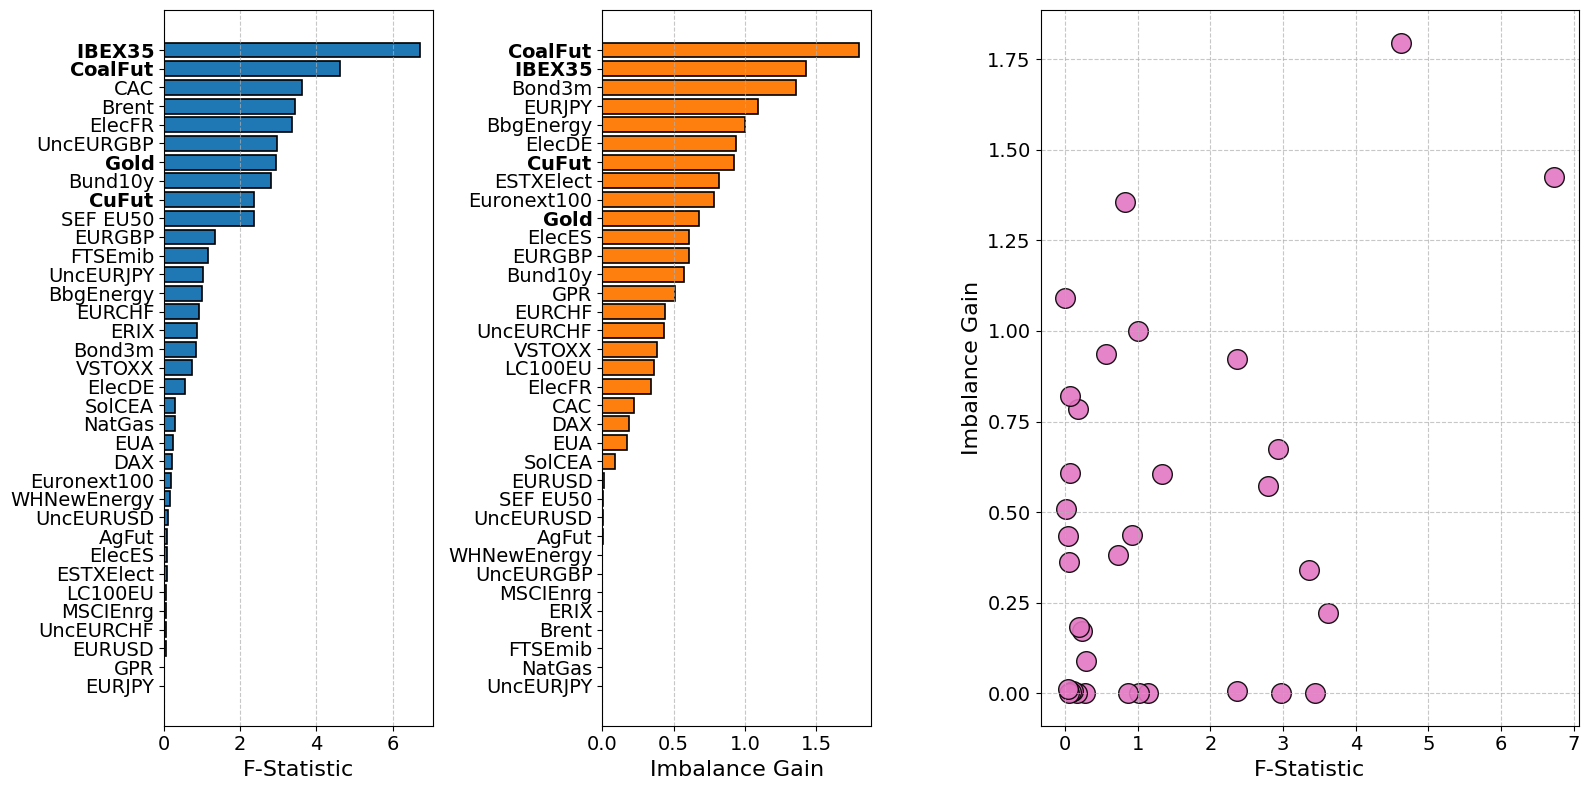

In [88]:
bold_vars = ["IBEX35", "CoalFut", "Gold", "CuFut"]

causality_results_df["Variable"] = causality_results_df["Variable"].apply(
    lambda x: f"$\\bf{{{x}}}$" if x in bold_vars else x
)

df_IG_Rets_1["Variable"] = df_IG_Rets_1["Variable"].apply(
    lambda x: f"$\\bf{{{x}}}$" if x in bold_vars else x
)

fig, axes = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1, 2]})

bar_kwargs = {"edgecolor": "black", "linewidth": 1.2}

axes[0].barh(
    causality_results_df["Variable"], 
    causality_results_df["F-Statistic"], 
    color='tab:blue', 
    **bar_kwargs
)

axes[0].set_xlabel("F-Statistic", fontsize=16)
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

axes[1].barh(
    df_IG_Rets_1["Variable"], 
    df_IG_Rets_1["IG Coeff."], 
    color='tab:orange', 
    **bar_kwargs
)

axes[1].set_xlabel("Imbalance Gain", fontsize=16)
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

axes[2].scatter(
    merged_df_2["F-Statistic"], 
    merged_df_2["IG Coeff."], 
    color='tab:pink', 
    alpha=0.9, s=200, edgecolor='black'
)

axes[2].set_xlabel("F-Statistic", fontsize=16)
axes[2].set_ylabel("Imbalance Gain", fontsize=16)
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

***

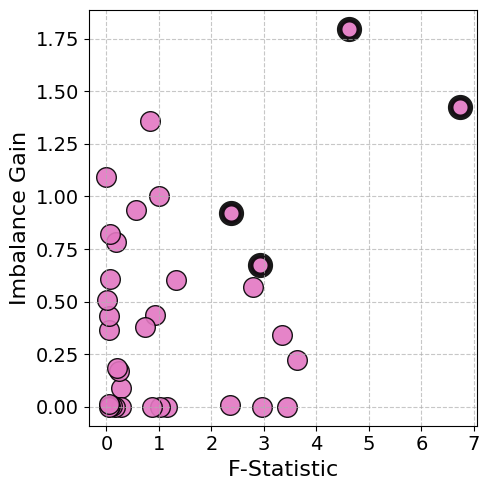

In [89]:
bold_vars = ["IBEX35", "CoalFut", "Gold", "CuFut"]

fig, ax = plt.subplots(figsize=(5, 5))

scatter_kwargs = {
    "color": 'tab:pink', 
    "alpha": 0.9, 
    "s": 200, 
    "edgecolor": 'black'
}

for var in merged_df_2["Variable"]:
    if var in bold_vars:
        ax.scatter(
            merged_df_2.loc[merged_df_2["Variable"] == var, "F-Statistic"], 
            merged_df_2.loc[merged_df_2["Variable"] == var, "IG Coeff."], 
            linewidths=4,  
            **scatter_kwargs
        )
        # ax.text(
        #     merged_df_2.loc[merged_df_2["Variable"] == var, "F-Statistic"].values[0], 
        #     merged_df_2.loc[merged_df_2["Variable"] == var, "IG Coeff."].values[0], 
        #     var, fontsize=12, weight='bold', ha='right'
        # )
    else:
        ax.scatter(
            merged_df_2.loc[merged_df_2["Variable"] == var, "F-Statistic"], 
            merged_df_2.loc[merged_df_2["Variable"] == var, "IG Coeff."], 
            linewidths=1.0,
            **scatter_kwargs
        )

ax.set_xlabel("F-Statistic", fontsize=16)
ax.set_ylabel("Imbalance Gain", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

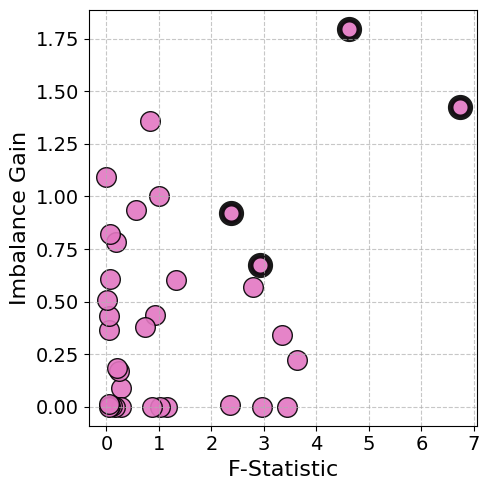

In [90]:
bold_vars = ["IBEX35", "CoalFut", "Gold", "CuFut"]

fig, ax = plt.subplots(figsize=(5, 5))

scatter_kwargs = {
    "color": 'tab:pink', 
    "alpha": 0.9, 
    "s": 200, 
    "edgecolor": 'black'
}

for var in merged_df_2["Variable"]:
    if var in bold_vars:
        ax.scatter(
            merged_df_2.loc[merged_df_2["Variable"] == var, "F-Statistic"], 
            merged_df_2.loc[merged_df_2["Variable"] == var, "IG Coeff."], 
            linewidths=4,
            **scatter_kwargs
        )
        # ax.text(
        #     merged_df_2.loc[merged_df_2["Variable"] == var, "F-Statistic"].values[0], 
        #     merged_df_2.loc[merged_df_2["Variable"] == var, "IG Coeff."].values[0], 
        #     var, fontsize=8, ha='right'
        # )
    else:
        ax.scatter(
            merged_df_2.loc[merged_df_2["Variable"] == var, "F-Statistic"], 
            merged_df_2.loc[merged_df_2["Variable"] == var, "IG Coeff."], 
            linewidths=1.0,
            **scatter_kwargs
        )

ax.set_xlabel("F-Statistic", fontsize=16)
ax.set_ylabel("Imbalance Gain", fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()